# Comparison between ADVI and MCMC
## Model timeseries using Gaussian Processes

In [2]:
## Import necessary stuff
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np
import pymc3 as pm

/opt/conda/envs/biospytial/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


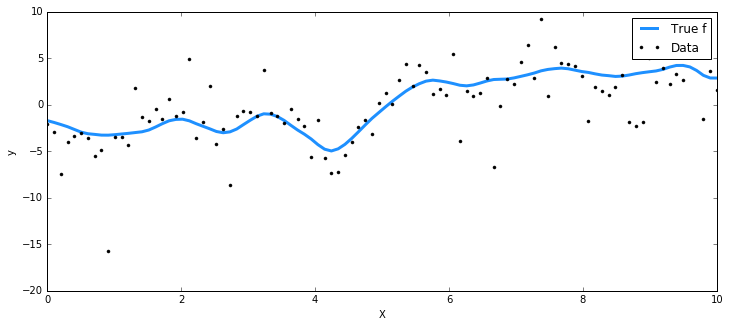

In [11]:
## Simulation of the data
# set the seed
#np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
l_true = 1.0
n_true = 3.0
cov_func = n_true**2 * pm.gp.cov.Matern52(1, l_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
s_true = 2.0
v_true = 3.0
y = f_true + s_true * np.random.standard_t(v_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

In [72]:
with pm.Model() as model1:
    l = pm.Gamma("l",alpha=2,beta=1)
    n = pm.HalfCauchy("n",beta=5)
    
    cov = n ** 2 * pm.gp.cov.Matern52(1,l)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f",X=X)
    
    sigma = pm.HalfCauchy("sigma",beta=5)
    v = pm.Gamma("v",alpha=2,beta=0.1)
    
    y_ = pm.StudentT("y",mu=f,lam=1.0/sigma,nu=v,observed=y)
    #y_ = pm.Normal("y",mu=f,observed=y)
    trace_m1 = pm.sample(100)
    

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_log__, sigma_log__, f_rotated_, n_log__, l_log__]
100%|██████████| 600/600 [03:13<00:00,  3.10it/s]


## We can calulate map but: as it says in the doc:
The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the find_MAP function.

Below we find the MAP for our original model. The MAP is returned as a parameter point, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values.


In [66]:
#map_estimate = pm.find_MAP(model=model)
#map_estimate

In [75]:
with pm.Model() as model2:
    l = pm.Gamma("l",alpha=2,beta=1)
    n = pm.HalfCauchy("n",beta=5)
    
    cov = n ** 2 * pm.gp.cov.Matern52(1,l)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f",X=X)
    
    sigma = pm.HalfCauchy("sigma",beta=5)
    v = pm.Gamma("v",alpha=2,beta=0.1)
    
    #y_ = pm.StudentT("y",mu=f,lam=1.0/sigma,nu=v,observed=y)
    y_ = pm.Normal("y",mu=f,sd=sigma ,observed=y)
    trace_m2 = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_log__, sigma_log__, f_rotated_, n_log__, l_log__]
100%|██████████| 600/600 [02:26<00:00,  4.08it/s]


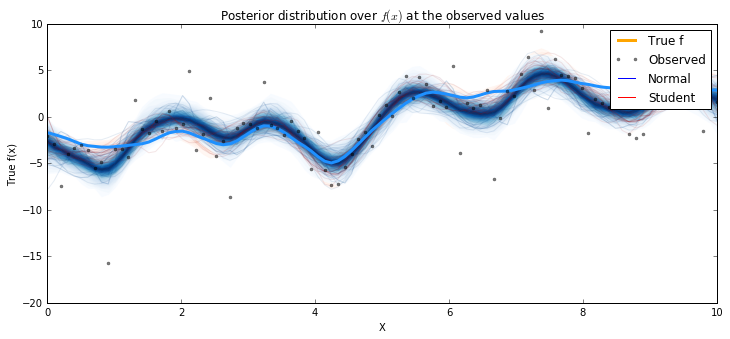

In [82]:
# plot the results
fig = plt.figure(figsize=(12,5));
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

m1 = plot_gp_dist(ax, trace_m1["f"], X,palette='Reds');
m2 = plot_gp_dist(ax, trace_m2["f"], X,palette='Blues');

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); 
plt.ylabel("True f(x)");

blue_normal = mlines.Line2D([], [], color='blue',label='normal')
red_student = mlines.Line2D([], [], color='red', label='student')

plt.legend([truth,obs,blue_normal,red_student],("True f","Observed","Normal","Student"));

plt.title("Posterior distribution over $f(x)$ at the observed values"); 


In [54]:
## With ADVI method
with model:
    %time mean_field = pm.fit(method='advi',n=1500)    
    %time tracef = mean_field.sample(draws=5000)

Average Loss = 391.13: 100%|██████████| 1500/1500 [00:03<00:00, 427.35it/s]
Finished [100%]: Average Loss = 390.02


CPU times: user 16.1 s, sys: 148 ms, total: 16.2 s
Wall time: 6.33 s
CPU times: user 12.9 s, sys: 88 ms, total: 13 s
Wall time: 3.6 s


In [35]:
import matplotlib.lines as mlines
#'import matplotlib.pyplot as plt


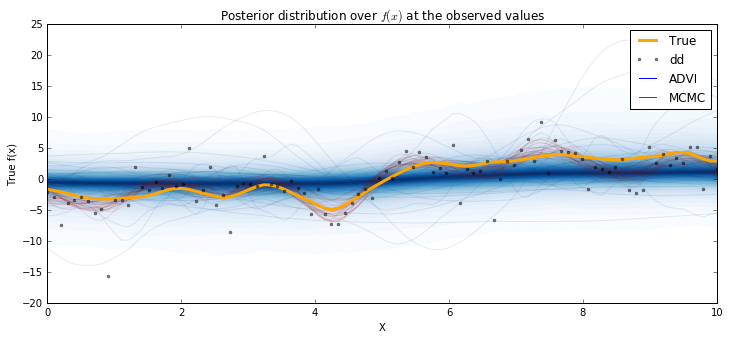

In [55]:


# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
mcmc = plot_gp_dist(ax, trace["f"], X,palette='Reds');
advi = plot_gp_dist(ax,tracef['f'],X,palette='Blues');

# plot the data and the true latent function
truth, = plt.plot(X, f_true, "orange", lw=3, label="True f");
obs, = plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X");
plt.ylabel("True f(x)");

plt.title("Posterior distribution over $f(x)$ at the observed values"); 
blue_advi = mlines.Line2D([], [], color='blue',label='Blue stars')
red_mcmc = mlines.Line2D([], [], color='red', label='Blue stars')

plt.legend([truth,obs,blue_advi,red_mcmc],("True","dd","ADVI","MCMC"));

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d4e7bb590>,
      dtype=object)

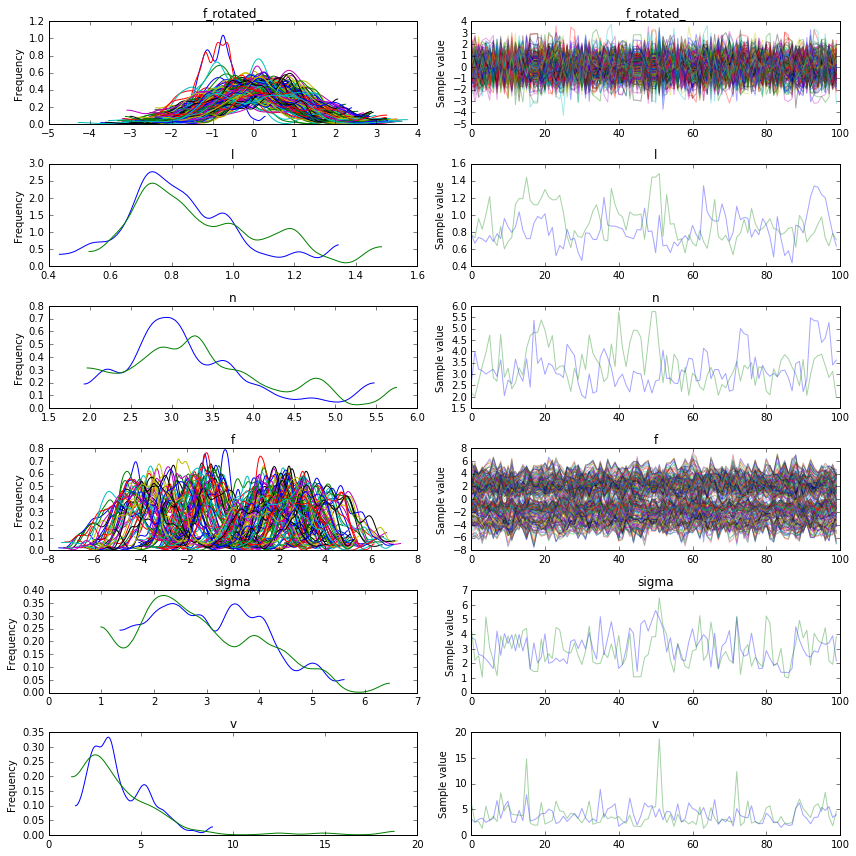

In [57]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d880fb210>,
      dtype=object)

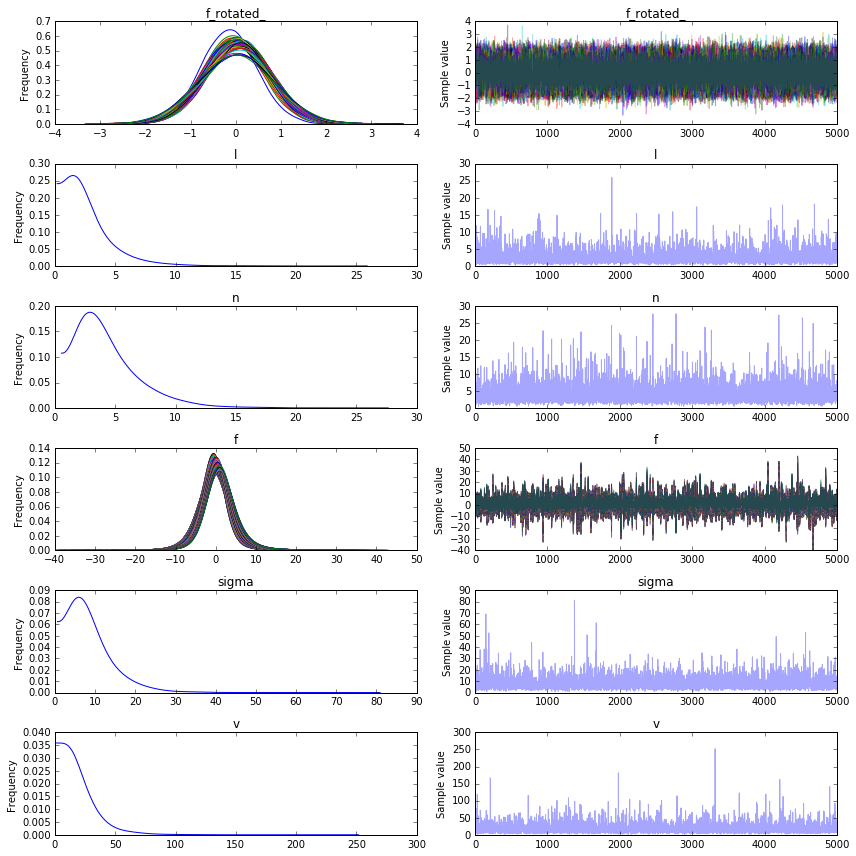

In [58]:
pm.traceplot(tracef)